### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# MiDaS

*Author: Intel ISL*

**MiDaS models for computing relative depth from a single image.**

<img src="https://pytorch.org/assets/images/midas_samples.png" alt="alt" width="50%"/>


### Model Description

[MiDaS](https://arxiv.org/abs/1907.01341) computes relative inverse depth from a single image. The repository provides multiple models that cover different use cases ranging from a small, high-speed model to a very large model that provide the highest accuracy. The models have been trained on 10 distinct datasets using
multi-objective optimization to ensure high quality on a wide range of inputs.

### Dependencies

MiDaS depends on [timm](https://github.com/rwightman/pytorch-image-models). Install with

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install h5py
import h5py

In [3]:
import scipy.io as sio
mat_path = "/content/drive/MyDrive/nyu_depth_v2_labeled.mat"

In [4]:
with h5py.File(mat_path, 'r') as f:
    print(list(f.keys()))
    # 这里会列出顶层数据集/组的名称，比如 "images", "depths", ...

    # 若想访问某个数据集，比如 'images'
    images = f['images'][:]  # 转成 numpy array
    depths = f['depths'][:]
    print(images.shape, depths.shape)

['#refs#', '#subsystem#', 'accelData', 'depths', 'images', 'instances', 'labels', 'names', 'namesToIds', 'rawDepthFilenames', 'rawDepths', 'rawRgbFilenames', 'sceneTypes', 'scenes']
(1449, 3, 640, 480) (1449, 640, 480)


In [7]:
import os
import h5py
import torch
import numpy as np
from torch.utils.data import Dataset

class NYUv2MatHDF5(Dataset):
    def __init__(self, mat_path, transform=None):
        """
        mat_path: 形如 "/content/drive/MyDrive/nyu_depth_v2_labeled.mat"
        transform: 可选，对 (image, depth) 做进一步缩放/增强
        """
        self.transform = transform

        # 读取 v7.3 (HDF5) 格式的 .mat 文件
        with h5py.File(mat_path, 'r') as f:
            # 这里要看具体有哪些键，通常 "images" / "depths" 是常见名称
            self.images = f['images'][:]   # => numpy array
            self.depths = f['depths'][:]   # => numpy array

        # 可能 shapes 是 (H, W, 3, N) / (H, W, N)
        # 取决于 nyu_depth_v2_labeled.mat 内部存储方式
        # 这里假设 images.shape = (H, W, 3, N), depths.shape = (H, W, N)
        # 转换到 (N, H, W, 3) / (N, H, W)
        self.images = self.images.transpose((0, 3, 2, 1))  # => (N,H,W,3)
        self.depths = self.depths.transpose((0, 2, 1))      # => (N,H,W)
        print("After transpose, self.images.shape =", self.images.shape)
        print("After transpose, self.depths.shape =", self.depths.shape)

        # 样本总数
        self.length = self.images.shape[0]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        img = self.images[idx]   # shape (H,W,3)
        depth = self.depths[idx] # shape (H,W)

        # 转 float32
        img = img.astype(np.float32)
        depth = depth.astype(np.float32)

        # 若有自定义transform (e.g. resize/crop/augment)，这里执行
        if self.transform:
            img, depth = self.transform(img, depth)

        # 转 PyTorch Tensor:
        #   - 图像 [H,W,3] => [3,H,W]
        #   - 深度 [H,W] => [1,H,W]
        img_tensor = torch.from_numpy(img).permute(2,0,1)   # [3,H,W]
        depth_tensor = torch.from_numpy(depth).unsqueeze(0)  # [1,H,W]

        return img_tensor, depth_tensor


In [8]:
from torch.utils.data import DataLoader
mat_file = "/content/drive/MyDrive/nyu_depth_v2_labeled.mat"  # 你在Drive里的.mat文件路径
nyu_dataset = NYUv2MatHDF5(mat_file)

# 创建 DataLoader
nyu_loader = DataLoader(
    nyu_dataset,
    batch_size=4,   # 一次取4个样本
    shuffle=True,   # 打乱顺序
)

After transpose, self.images.shape = (1449, 480, 640, 3)
After transpose, self.depths.shape = (1449, 480, 640)


In [10]:
for batch_idx, (images, depths) in enumerate(nyu_loader):
    print("Batch index:", batch_idx)
    print("images shape:", images.shape)  # [B, 3, H, W]
    print("depths shape:", depths.shape)  # [B, 1, H, W]
    break

Batch index: 0
images shape: torch.Size([4, 3, 480, 640])
depths shape: torch.Size([4, 1, 480, 640])


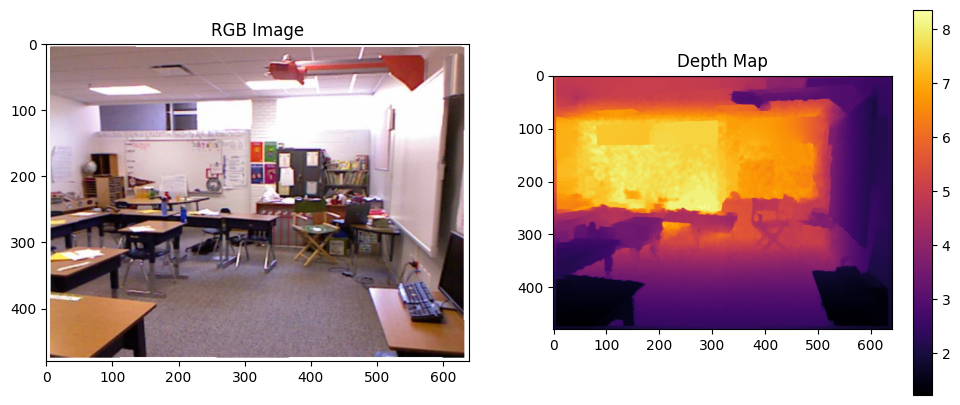

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 获取第一个 batch
images, depths = next(iter(nyu_loader))

# 将第0张图像从 tensor 转为 numpy（注意 permute 回 HWC）
img_np = images[0].permute(1, 2, 0).cpu().numpy().astype(np.uint8)  # [H,W,3]
depth_np = depths[0].squeeze().cpu().numpy()  # [H,W]

# 显示图像和深度图
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("RGB Image")
plt.imshow(img_np)

plt.subplot(1, 2, 2)
plt.title("Depth Map")
plt.imshow(depth_np, cmap='inferno')
plt.colorbar()
plt.show()

In [13]:
from torch.utils.data import random_split
total_size = len(nyu_dataset)  # 应为 1449
train_size = int(0.9 * total_size)
val_size = total_size - train_size

train_dataset, val_dataset = random_split(nyu_dataset, [train_size, val_size])

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [14]:
pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 352.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 27.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

### Example Usage

Download an image from the PyTorch homepage

In [15]:
import cv2
import torch
import urllib.request

import matplotlib.pyplot as plt

url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
urllib.request.urlretrieve(url, filename)

('dog.jpg', <http.client.HTTPMessage at 0x7df818b3bd10>)

Load a model (see [https://github.com/intel-isl/MiDaS/#Accuracy](https://github.com/intel-isl/MiDaS/#Accuracy) for an overview)

In [16]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.l

Move model to GPU if available

In [17]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.train()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

In [18]:
import torchvision.transforms as T

image_size = (384, 384)  # 可调（MiDaS v2.1 用 256x256, 384x384 等）

train_transform = T.Compose([
    T.ToTensor(),  # 自动转为 [0,1], 形状为 [C,H,W]
    T.Resize(image_size),  # 图像缩放
])


Load transforms to resize and normalize the image for large or small model

In [19]:
import torch.nn.functional as F
import torch.optim as optim

optimizer = optim.Adam(midas.parameters(), lr=1e-4)

def masked_l1_loss(pred, target):
    mask = (target > 0).float()
    loss = torch.abs(pred - target) * mask
    return loss.sum() / (mask.sum() + 1e-8)

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    midas.train()
    total_loss = 0.0

    for images, depths in train_loader:
        images = images.to(device)
        depths = depths.to(device)

        optimizer.zero_grad()

        preds = midas(images)
        if preds.dim() == 3:
            preds = preds.unsqueeze(1)

        loss = masked_l1_loss(preds, depths)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Train Loss: {total_loss / len(train_loader):.4f}")


In [ ]:
midas.eval()
with torch.no_grad():
    val_loss = 0.0
    for images, depths in val_loader:
        images = images.to(device)
        depths = depths.to(device)

        preds = midas(images).unsqueeze(1)
        loss = masked_l1_loss(preds, depths)
        val_loss += loss.item()
    print(f"Validation Loss: {val_loss / len(val_loader):.4f}")


In [ ]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Load image and apply transforms

In [ ]:
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

Predict and resize to original resolution

In [ ]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

Show result

In [ ]:
plt.imshow(output)
# plt.show()

### References
[Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer](https://arxiv.org/abs/1907.01341)

[Vision Transformers for Dense Prediction](https://arxiv.org/abs/2103.13413)

Please cite our papers if you use our models:

In [ ]:
@article{Ranftl2020,
	author    = {Ren\'{e} Ranftl and Katrin Lasinger and David Hafner and Konrad Schindler and Vladlen Koltun},
	title     = {Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer},
	journal   = {IEEE Transactions on Pattern Analysis and Machine Intelligence (TPAMI)},
	year      = {2020},
}

In [ ]:
@article{Ranftl2021,
	author    = {Ren\'{e} Ranftl and Alexey Bochkovskiy and Vladlen Koltun},
	title     = {Vision Transformers for Dense Prediction},
	journal   = {ArXiv preprint},
	year      = {2021},
}